In [1]:
# Wizualizacja funkcji sigmoidalnej
import matplotlib.pyplot as plt 
import numpy as np 

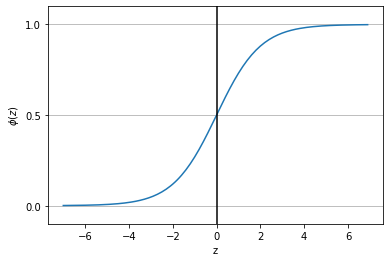

In [2]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')

plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# Jednostyki osi y i siatka
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.show()

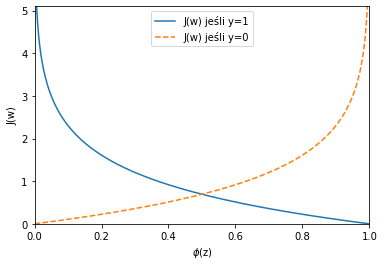

In [3]:
# Wykres ilustrujący koszt klasyfikacji jednego przykładu
def cost_1(z):
    return - np.log(sigmoid(z))
def cost_0(z):
    return - np.log(1 - sigmoid(z))
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) jeśli y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) jeśli y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.show()

In [4]:
# Implementacja regresji logistycznej
# Przeróbka algorytmu Adaline

class LogisticRegressionGD(object):
    """Klasyfikator - regresja ligistyczna z wykorzystaniem
       metody gradientu prostego

    Parametry
    --------
    eta: zmiennoprzecinkowy
        współczynnik uczenia (0.0 - 1.0)
    n_iter: liczba całkowita
            Liczba przebiegów po training set
    random_state: liczba całkowita
            ziarno generatora liczb losowych
    
    Atrybuty
    -------
    w_: jednowymiarowa tablica
        wagi po dopasowaniu
    cost_: lista
            suma kwadratów błędów w każdej epoce
    """

    def __init__ (self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Trenowanie za pomocą danych uczących

        Parametry
        --------
        X: {tablicopodobny}, wymiary [n_probek, n_cech]
            wektory uczenia
        y: {tablicopodobny}, wymiary [n_probek]
            wartości docelowe
        Zwraca
        -----
        self: obiekt
        """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            # Tu występuje różnica między LR a Adaline
            # Inaczej obliczany jest koszt

            cost = (-y.dot(np.log(output)) - 
                        ((1 - y).dot(np.log(1 - output))))
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Oblicza całkowite pobudzenie"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Oblicza liniową funkcję aktywacji"""
        # Tu występuje różnica między LR a Adaline
        # Sigmoidalna funkcja aktywacji
        activate_value = 1. / (1. + np.exp(-np.clip(z, -250, 250)))
        return activate_value

    def predict(self, X):
        """Zwraca rtykietę klas po wykonaniu skoku jednostkowego"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)



In [5]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1, stratify=y)
X_train_01_subset = X_train[y_train == 0 | (y_train ==1)]
y_train_01_subset = y_train[y_train == 0 | (y_train ==1)]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# sc.fit oblicza wartość średnią próbek 
# oraz odchylenie standardowe
sc.fit(X_train)
# transform - standaryzacja danych
# na podstawie wartości obliczonych dzięki fit
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [6]:
# zobaczymy jak wygląda granica przebiegająca między etykietami
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx = None, resolution=0.02):

    # konfiguracja generatora znaczników i mapy kolorów

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # wykresy powierzchni decyzyjnej
    x1_min, x1_max = X[:, 0].min() -1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # narysuj wykres z próbkami

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
            alpha=0.8, c=colors[idx],
            marker=markers[idx], label=cl,
            edgecolor='black')

    # zaznacz próbki testowe
    if test_idx:
        # rysuj wykres wszystkich próbek
        X_test, y_Test = X[list(test_idx), :], y[list(test_idx)]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black',
        alpha=1.0, linewidth=1, marker='o', edgecolors='k',
        s=100, label='Zestaw testowy')



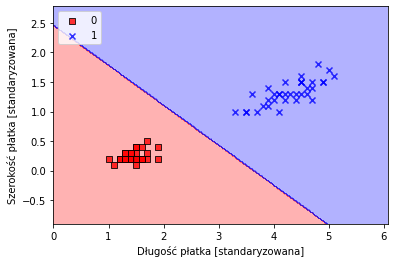

In [7]:
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier = lrgd)
plt.xlabel('Długość płatka [standaryzowana]')
plt.ylabel('Szerokość płatka [standaryzowana]')
plt.legend(loc='upper left')
plt.show()

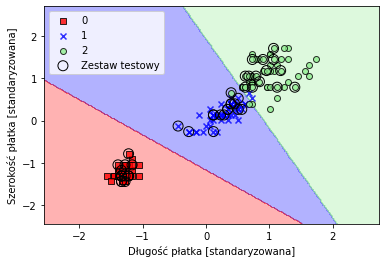

In [8]:
# Implementacja przy pomocy scikit-learn
from sklearn.linear_model import LogisticRegression
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
lr = LogisticRegression(C=1000.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined, 
                      classifier=lr, 
                      test_idx=range(105, 150))
plt.xlabel('Długość płatka [standaryzowana]')
plt.ylabel('Szerokość płatka [standaryzowana]')
plt.legend(loc='upper left')
plt.show()        

In [9]:
# Wyciąganie prawdopodobieństwa przynależności do klasy
# W odpowiedzi otrzymujemy prawdopodobieństwo przynalezności
# do każdej z klas, prawdop. w wierszu się sumują do 1
lr.predict_proba(X_test_std[:3, :])

array([[1.31412372e-16, 8.89570135e-05, 9.99911043e-01],
       [9.98945705e-01, 1.05429541e-03, 2.05075813e-19],
       [9.99881982e-01, 1.18018083e-04, 9.17897848e-22]])

In [10]:
# Zwróćmy listę próbek z informacją, 
# dla której klasy były max prawdopodobieństwa
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [11]:
# A teraz zwykła predykcja
# Oczywiście pokrywa się z wnioskami wyżej
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [12]:
# Przewidywanie na jednej próbce jedynie z użyciem funkcji reshape
# scikit learn oczekuje dwuwymiarowej tablicy
# Możemy w taką przekształcić za pomoca reshape

lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

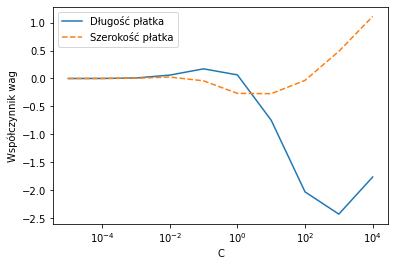

In [17]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:,0], label='Długość płatka')
plt.plot(params, weights[:,1], label='Szerokość płatka', linestyle='--')
plt.ylabel('Współczynnik wag')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()